In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

#### I started off here getting some fresh NBA data from basketball-reference.com. Since we can all recognize that points per game is a barbaric stat to just all players by, I decided to let the advanced stats tell a better story. Specifically, I was thinking of PER, or player efficiency rating, and VORP, or value over replacement player. There are some others, but here are all of explainations:

[Player Efficiency Rating](http://www.basketball-reference.com/about/per.html)
strives to measure a player's per-minute performance, while adjusting for pace. A league-average PER is always 15.00, which permits comparisons of player performance across seasons.

[Box Plus Minus](http://www.basketball-reference.com/about/bpm.html#)
relies on a player's box score information and the team's overall performance to estimate a player's performance relative to league average. BPM is a per-100-possession stat, the same scale as Adjusted Plus/Minus: 0.0 is league average, +5 means the player is 5 points better than an average player over 100 possessions (which is about All-NBA level), -2 is replacement level, and -5 is really bad.

[Value Over Replacement Player](http://www.basketball-reference.com/about/bpm.html#vorp)
converts the BPM rate into an estimate of each player's overall contribution to the team, measured vs. what a theoretical "replacement player" would provide, where the "replacement player" is defined as a player on minimum salary or not a normal member of a team's rotation. (Whose VORP is defined as -2.0)

[Win Share](http://www.basketball-reference.com/about/ws.html)
is a player statistic which attempts to divvy up credit for team success to the individuals on the team. Full details are available below, but the important things to note are that it is calculated using player, team and league-wide statistics and the sum of player win shares on a given team will be roughly equal to that team’s win total for the season. WS/48 basically takes a player's win share total and normalizes it over the duration of a basketball game, which is 48 minutes long.

#### Obviously all of these stats have their strengths and weaknesses, but they are all trying to use statistics to describe an individual player's contribution to his team. 
* PER is good because it takes into account many things like game situation and pace. It is also useful for comparing players across years, since the league average should always be about 15.
* PER is dumb because 15? Where the heck did that come from? Oh yeah, it's just what John Hollinger, the guy who invented the formula, decided for some reason. Also it probably over-rates offensive performance and generally warps the picture to fit what John Hollinger values in basketball.
* BPM and BPM/48 are good because they much better account for defensive and overall play that is not statistically capturable. For example, there is no stat for shots against or misses created, picks set or time spent in a good position. But generally, good individual play will result in good numbers in the box score. This stat is adjusted on a per 100 possessions basis, and in the case of BPM/48, per 48 minutes or per one complete game.
* BPM is bad because it probably exaggerates the effect of playing with good and/or bad teammates. Whereas PER doesn't care if you win the games or not, this stat basically only sees how many points your team scores compared to your opponent when you are on the floor. Random backups for the Golden State Warriors occasionally filling in while Curry and Thomson are still on the floor are probably not accounting for as much as this stat will imply. It does attempt to adjust for this with coefficients.
* VORP tries to better adjust for playing time by using BPM and factoring "usage", which has a long defintion that basically boils down to the percentage of your team's possessions that you "used up" by shooting the ball or getting it stolen. It, like PER, attempts to be an all around stat that can be useful across seasons.
* It also has many of the same problems as BPM, since it uses BPM in its calculation. Oh, also the "replacement player" they are talking about has a value of -2, which means he is actually actively taking away wins from the team. This makes a strange amount of sense to me.

#### So yeah, a wall of text that basically says that these stats are all flawed, but still much, much better than points per game.

#### I figured I would also get the latest contract information, since next year's contracts are already known. Basketball-reference actually lists them by year until the end of the contract, and lists the player's guaranteed money separately. I thought this might be useful but maybe not.

In [45]:
raw_stats_df=pd.read_csv('/home/sean/Documents/NBA_stats_2015-16_combined.csv')
raw_contracts_df=pd.read_csv('/home/sean/Documents/NBA_contracts_no_dups.csv')

In [47]:
raw_contracts_df[raw_contracts_df['Player']=='LeBron James']
# i literally just went on this whole huge odyssey just to get lebron in here. i feel like he should be in here, after all
# i will now re-run every step that matters

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
424,430,LeBron James,CLE,$30300000,NaN,NaN,NaN,NaN,NaN,NaN,$30300000


In [102]:
raw_contracts_df.columns

Index(['Rk', 'Player', 'Tm', '2016-17', '2017-18', '2018-19', '2019-20',
       '2020-21', '2021-22', 'Signed Using', 'Guaranteed'],
      dtype='object')

In [22]:
# turns out there are duplicate entries where the player was traded midseason and got a new contract.
contracts_df[contracts_df['Player'].duplicated()]
# this returns false now because i manually removed the 5 of them from the csv

,Player,Tm,2016-17,Guaranteed


In [213]:
# our stats file did not have this problem because we handled it at the data source
raw_stats_df[raw_stats_df['Player'].duplicated()]

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP


In [227]:
# we're going to drop the duplicate contracts of the starting team, keeping the team the player wound up on
raw_contracts_df[(raw_contracts_df['Player']=='Deron Williams')]# & (raw_contracts_df['Tm']=='BRK')]

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
102,103,Deron Williams,DAL,$10000000,NaN,NaN,NaN,NaN,NaN,Cap Space,$10000000
169,170,Deron Williams,BRK,$5500000,$5500000,$5500000,$5500000,NaN,NaN,NaN,$22000000


In [228]:
raw_contracts_df[(raw_contracts_df['Player']=='Anderson Varejao')]

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
283,284,Anderson Varejao,POR,$1984005,$1984005,$1984005,$1984005,$1984005,NaN,NaN,$9920025
300,301,Anderson Varejao,GSW,$1551659,NaN,NaN,NaN,NaN,NaN,Minimum Salary,$1551659


In [229]:
raw_contracts_df[(raw_contracts_df['Player']=='Wayne Ellington')]

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
153,154,Wayne Ellington,MIA,$6000000,$6270000,NaN,NaN,NaN,NaN,Cap Space,$6000000
374,375,Wayne Ellington,SAC,$923670,NaN,NaN,NaN,NaN,NaN,NaN,$6923780


In [230]:
raw_contracts_df[(raw_contracts_df['Player']=='Maurice Ndour')]

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
410,411,Maurice Ndour,NYK,$543471,$905249,NaN,NaN,NaN,NaN,Minimum Salary,$543471
424,425,Maurice Ndour,DAL,$437318,NaN,NaN,NaN,NaN,NaN,NaN,$980789


In [231]:
raw_contracts_df[(raw_contracts_df['Player']=='Jarrett Jack')]

,Rk,Player,Tm,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22,Signed Using,Guaranteed
302,303,Jarrett Jack,ATL,$1551659,NaN,NaN,NaN,NaN,NaN,Minimum Salary,$1551659
428,429,Jarrett Jack,BRK,$166666,$166667,$166667,NaN,NaN,NaN,NaN,$500000


In [ ]:
# i was hoping for an easy way to do this in place but theyre not in any particular order. removing manually in libreoffice and reloading...

In [48]:
contracts_df=raw_contracts_df[['Player', 'Tm', '2016-17', 'Guaranteed']]

In [104]:
raw_stats_df.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

In [49]:
stats_df=raw_stats_df[['Player', 'Pos', 'Age', 'MP', 'PER', 'TS%', 'WS', 'WS/48', 'BPM', 'VORP']]

In [50]:
combined_df=pd.merge(on='Player', left=stats_df, right=contracts_df, how='inner')

In [51]:
test=stats_df[(~stats_df.Player.isin(combined_df.Player))&(~stats_df.Player.isin(combined_df.Player))]
test[test['Player']=='LeBron James']
len(test)

116

In [20]:
contracts_df[contracts_df['Player']=='Bradley Beal']

,Player,Tm,2016-17,Guaranteed


In [237]:
combined_df.head()

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,2016-17,Guaranteed
0,Jordan Adams,SG,21,15,17.3,0.427,0.0,0.015,1.9,0.0,MEM,$1465080,$1465080
1,Steven Adams,C,22,2014,15.5,0.621,6.5,0.155,2.1,2.1,OKC,$3140517,$3140517
2,Arron Afflalo,SG,30,2371,10.9,0.531,2.7,0.055,-2.4,-0.2,SAC,$12500000,$14000000
3,Alexis Ajinca,C,27,861,13.8,0.514,1.0,0.058,-4.5,-0.5,NOP,$4600000,$14800000
4,Cole Aldrich,C,27,800,21.3,0.626,3.5,0.209,4.8,1.4,MIN,$7643979,$17000000


In [54]:
# some extra cleaning and type casting here
combined_df['2016-17']=combined_df['2016-17'].str.replace('$', '')
combined_df['Guaranteed']=combined_df['Guaranteed'].str.replace('$', '')

In [31]:
combined_df.head()

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,2016-17,Guaranteed
0,Jordan Adams,SG,21,15,17.3,0.427,0.0,0.015,1.9,0.0,MEM,1465080,1465080
1,Steven Adams,C,22,2014,15.5,0.621,6.5,0.155,2.1,2.1,OKC,3140517,3140517
2,Arron Afflalo,SG,30,2371,10.9,0.531,2.7,0.055,-2.4,-0.2,SAC,12500000,14000000
3,Alexis Ajinca,C,27,861,13.8,0.514,1.0,0.058,-4.5,-0.5,NOP,4600000,14800000
4,Cole Aldrich,C,27,800,21.3,0.626,3.5,0.209,4.8,1.4,MIN,7643979,17000000


In [55]:
combined_df['Salary']=combined_df['2016-17'].astype(int)

In [56]:
combined_df['Total Contract']=combined_df['Guaranteed'].astype(int)

In [35]:
combined_df.head()

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,2016-17,Guaranteed,Salary,Total Contract
0,Jordan Adams,SG,21,15,17.3,0.427,0.0,0.015,1.9,0.0,MEM,1465080,1465080,1465080,1465080
1,Steven Adams,C,22,2014,15.5,0.621,6.5,0.155,2.1,2.1,OKC,3140517,3140517,3140517,3140517
2,Arron Afflalo,SG,30,2371,10.9,0.531,2.7,0.055,-2.4,-0.2,SAC,12500000,14000000,12500000,14000000
3,Alexis Ajinca,C,27,861,13.8,0.514,1.0,0.058,-4.5,-0.5,NOP,4600000,14800000,4600000,14800000
4,Cole Aldrich,C,27,800,21.3,0.626,3.5,0.209,4.8,1.4,MIN,7643979,17000000,7643979,17000000


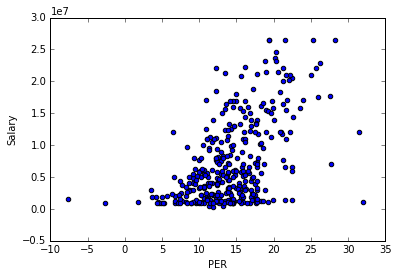

In [243]:
combined_df.plot(kind='scatter', x='PER', y='Salary')

In [57]:
# forgot to get rid of players with very few minutes. we will use 500 as a lower bound, and get rid of some columns we cant use
df=combined_df[combined_df['MP']>=500][['Player', 'Pos', 'Age', 'MP', 'PER', 'TS%', 'WS', 
                                     'WS/48', 'BPM', 'VORP', 'Tm', 'Salary', 'Total Contract']]
# after this last one, adding lebron, i can now go back and re-generate my charts. hopefully he's on one :P

This dataframe will be my working one. I cleaned it up a bit, converted some values, stripped out the ones I didn't want, and combined the contract info and player stats info into one. Next, I run some basic plots to make sure nothing is crazy.

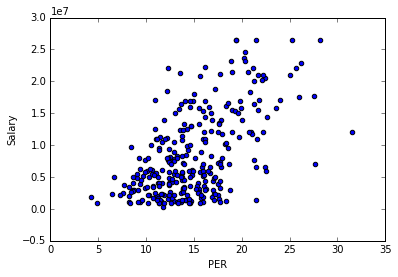

In [245]:
df.plot(kind='scatter', x='PER', y='Salary')

In [246]:
df[['PER', 'Salary']].describe()

,PER,Salary
count,293.000000,2.930000e+02
mean,14.851195,8.289975e+06
std,4.353762,6.540146e+06
min,4.200000,3.235990e+05
25%,11.800000,3.000000e+06
50%,14.200000,6.050000e+06
75%,17.500000,1.211236e+07
max,31.500000,2.654010e+07


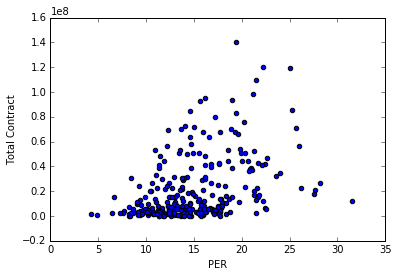

In [247]:
df.plot(kind='scatter', x='PER', y='Total Contract')

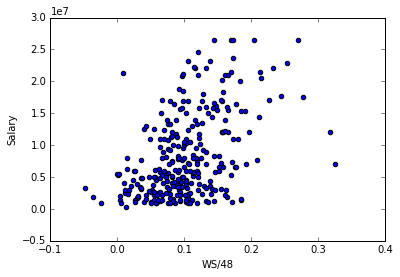

In [248]:
df.plot(kind='scatter', x='WS/48', y='Salary')

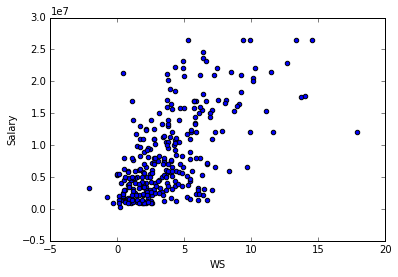

In [249]:
df.plot(kind='scatter', x='WS', y='Salary')

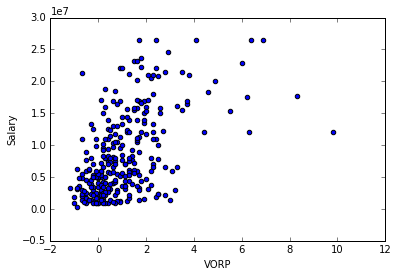

In [250]:
df.plot(kind='scatter', x='VORP', y='Salary')

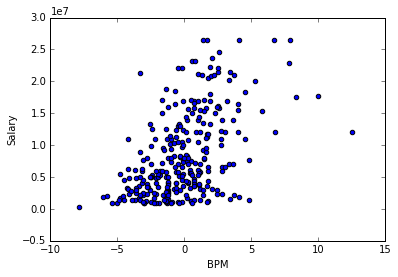

In [251]:
df.plot(kind='scatter', x='BPM', y='Salary')

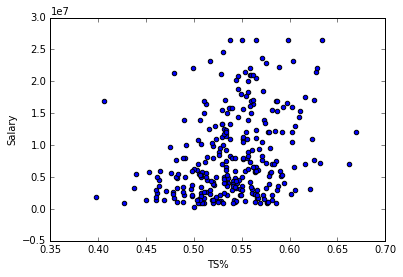

In [343]:
df.plot(kind='scatter', x='TS%', y='Salary')

Hmm, if PER and VORP are both flawed stats but have different flaws maybe multiplying them will be good!

In [418]:
(df['PER']*df['VORP']).describe()

count    293.000000
mean      19.895154
std       35.719782
min      -13.680000
25%        0.820000
50%        9.030000
75%       27.540000
max      308.700000
dtype: float64

Maybe not. What if we adjust for the average first?

In [420]:
((df['PER']/15)*(df['VORP']+2)).describe()

count    293.000000
mean       3.306503
std        2.829081
min        0.280000
25%        1.745333
50%        2.460000
75%        4.212000
max       24.780000
dtype: float64

Looks promising. Let's make a separate dataframe so we don't pollute the other once with nonsense, just in case

In [58]:
df[df['Player']=='LeBron James']

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract
162,LeBron James,SF,31,2709,27.5,0.588,13.6,0.242,9.1,7.6,CLE,30300000,30300000


In [61]:
test_df=df
test_df['Combined stats']=((test_df['PER']/15)*(test_df['VORP']+2))
test_df[test_df['Tm']=='CLE'].sort_values(by='Combined stats', ascending=False).head(40)

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,Combined stats
162,LeBron James,SF,31,2709,27.5,0.588,13.6,0.242,9.1,7.6,CLE,30300000,30300000,17.600000
201,Kevin Love,PF,27,2424,19.0,0.553,8.5,0.169,2.5,2.8,CLE,21500000,93500000,6.080000
159,Kyrie Irving,PG,23,1667,19.9,0.540,5.0,0.143,1.6,1.5,CLE,15851950,50873700,4.643333
318,Tristan Thompson,PF,24,2269,15.9,0.611,8.7,0.185,1.5,2.0,CLE,15330435,67739130,4.240000
108,Channing Frye,PF-C,32,1200,12.9,0.586,3.0,0.119,0.5,0.7,CLE,7456238,7456238,2.322000
348,Mo Williams,PG,33,748,12.4,0.527,1.1,0.067,-3.3,-0.2,CLE,2200000,2200000,1.488000
296,Iman Shumpert,SG,25,1316,8.4,0.475,1.7,0.063,-0.2,0.6,CLE,9700000,31000000,1.456000
93,Mike Dunleavy,SF,35,703,9.1,0.543,0.9,0.063,-2.1,0.0,CLE,4800000,9900000,1.213333


Well, it literally just occured to me that lebron james has been left out of this list. Time to redo some work :(

In [62]:
df[df['Player']=='LeBron James']
# yep, in there now

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,Combined stats
162,LeBron James,SF,31,2709,27.5,0.588,13.6,0.242,9.1,7.6,CLE,30300000,30300000,17.6


In [65]:
df.sort_values(by='VORP', ascending=False).head(10)

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,Combined stats
75,Stephen Curry,PG,27,2700,31.5,0.669,17.9,0.318,12.5,9.8,GSW,12112359,12112359,24.780000
339,Russell Westbrook,PG,27,2750,27.6,0.554,14.0,0.245,10.0,8.3,OKC,17769374,17769374,18.952000
162,LeBron James,SF,31,2709,27.5,0.588,13.6,0.242,9.1,7.6,CLE,30300000,30300000,17.600000
131,James Harden,SG,26,3125,25.3,0.598,13.3,0.204,6.7,6.9,HOU,26540100,85271293,15.011333
94,Kevin Durant,SF,27,2578,28.2,0.634,14.5,0.270,7.9,6.4,GSW,26540100,26540100,15.792000
202,Kyle Lowry,PG,29,2851,22.2,0.578,11.6,0.196,6.8,6.3,TOR,12000000,12000000,12.284000
192,Kawhi Leonard,SF,24,2380,26.0,0.616,13.7,0.277,8.3,6.2,SAS,17500000,56500000,14.213333
261,Chris Paul,PG,30,2420,26.2,0.575,12.7,0.253,7.8,6.0,LAC,22868828,22868828,13.973333
126,Draymond Green,PF,25,2808,19.3,0.587,11.1,0.190,5.8,5.5,GSW,15300000,67700000,9.650000
229,Paul Millsap,PF,30,2647,21.3,0.556,10.1,0.183,5.3,4.9,ATL,20000000,20000000,9.798000


In [71]:
# these will be used to generate labels for the chart
top_PER=df.sort_values(by='PER', ascending=False).head(20)
top_VORP=df.sort_values(by='VORP', ascending=False).head(20)
top_Salary=df.sort_values(by='Salary', ascending=False).head(20)

In [72]:
plt.scatter?

#### So these next two will be my real charts. My goal was to show every where every player in the league fell with regard to their quality of play vs their paycheck. I'm actually tracking 3 variables, since the marks will be sized according to win share, and then in a grid of salary in millions vs PER or VORP, depending on the chart. The chart will highlight the top 20 in PER or VORP in yellow and top 20 salary in red. Where the two intersect, they will turn orange, showcasing the ideal salary range for both the team and the player. (The player gets paid as much as possible and the team gets as much of a contribution as possible)

#### This not only shows the ideal range, it also really highlights outliers. From these charts, I would conclude that the best contract in the league (for the team) would be Stephen Curry, while the worst (for the team) is Derrick Rose. The best for both parties is LeBron James.

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


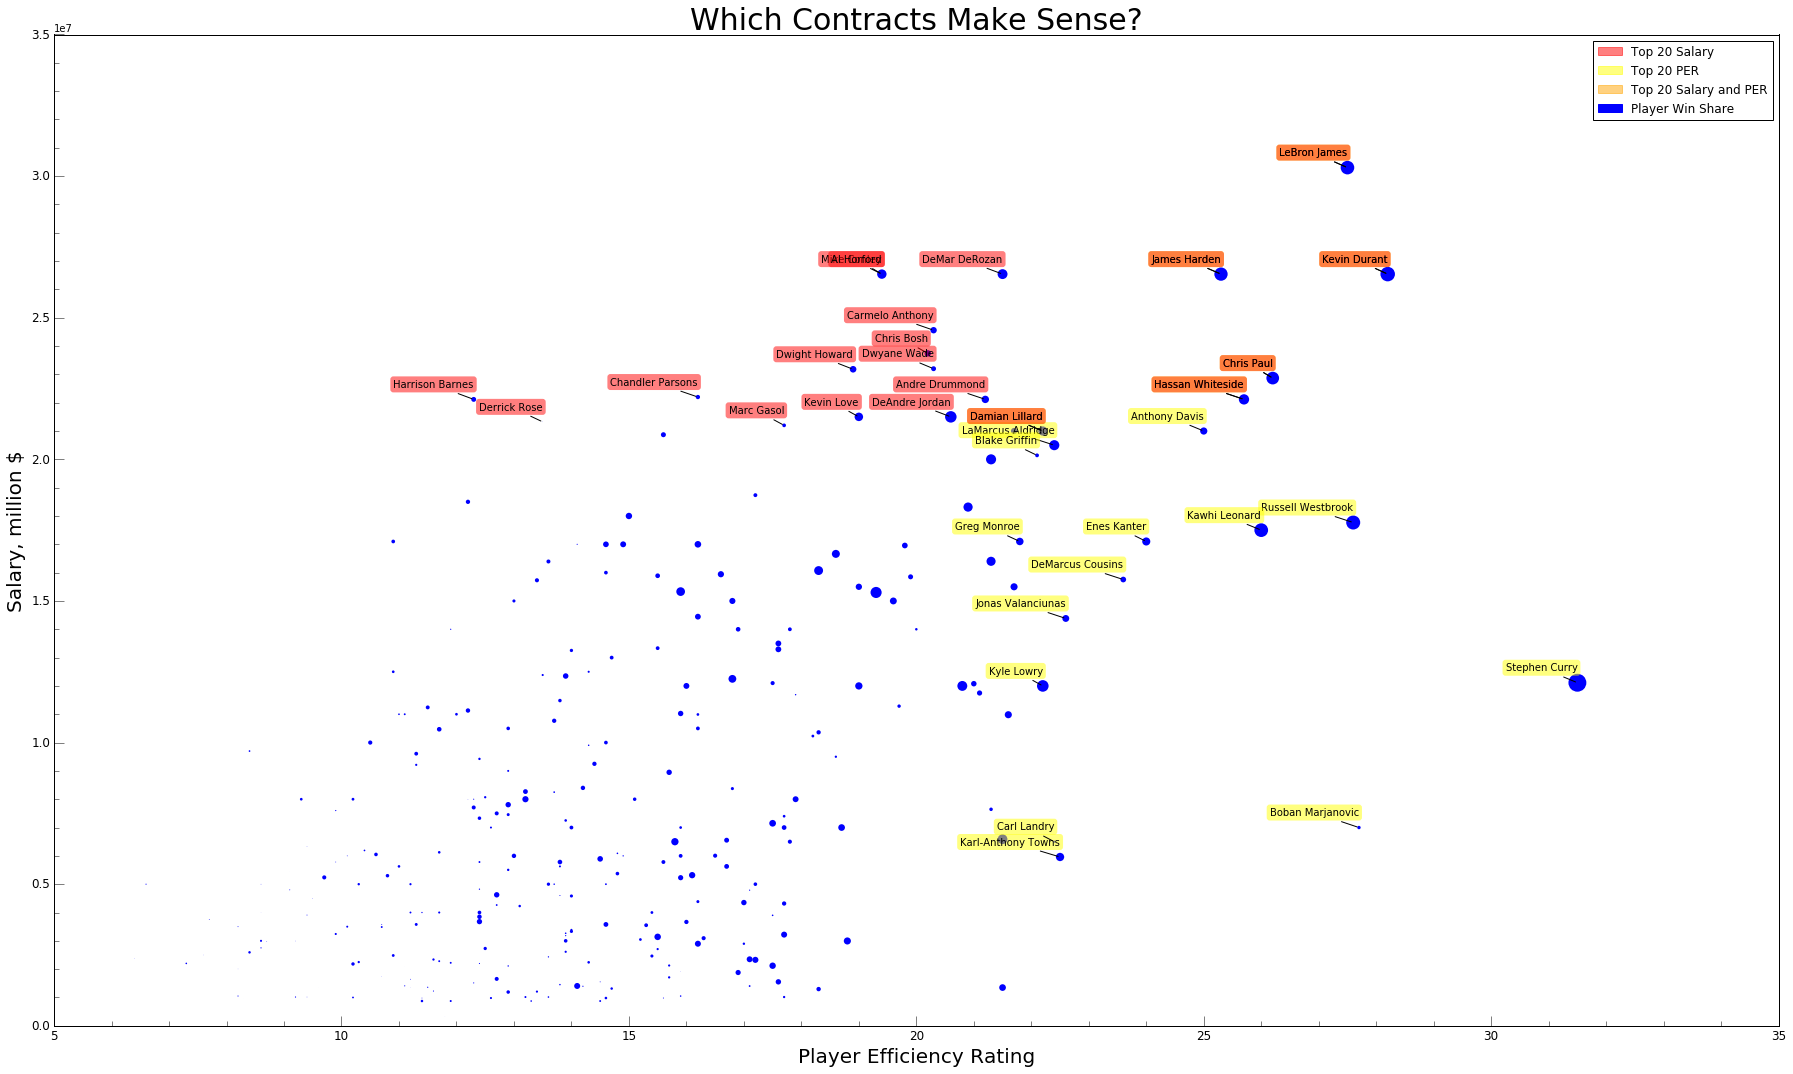

In [78]:
plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', length=10, top=False, right=False, color='black', bottom=True, left=True, labelsize='large')
plt.minorticks_on()
red_patch = mpatches.Patch(color='red', label='Top 20 Salary', alpha=0.5)
yellow_patch = mpatches.Patch(color='yellow', label='Top 20 PER', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Top 20 Salary and PER', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Player Win Share')
plt.legend(handles=[red_patch, yellow_patch, orange_patch, blue_patch])
plt.tick_params(axis='both', which='minor', length=5, top=False, right=False, color='black', 
                bottom=True, left=True, labelsize='small', labelbottom=True, labelleft=True)
plt.title('Which Contracts Make Sense?', fontsize='30')
plt.xlim(5,35)
plt.xlabel('Player Efficiency Rating', fontsize='20')
plt.ylim(0,35000000)
plt.ylabel('Salary, million $', fontsize='20')
plt.legend()
plt.scatter(
    df['PER'], df['Salary'], marker = 'o', 
    s = df['WS']**2,
    linewidths=0)
for label, x, y in zip(top_PER['Player'], top_PER['PER'], top_PER['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'yellow', alpha = 0.5, ec="none"),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))
for label, x, y in zip(top_Salary['Player'], top_Salary['PER'], top_Salary['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'red', alpha = 0.5, ec="none"),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

plt.tight_layout()
plt.savefig('nba_player_values_PER_v2_2.pdf', transparent=True)
plt.show()

In [75]:
df['VORP'].describe()

count    294.000000
mean       1.046939
std        1.560271
min       -1.200000
25%        0.100000
50%        0.700000
75%        1.700000
max        9.800000
Name: VORP, dtype: float64

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


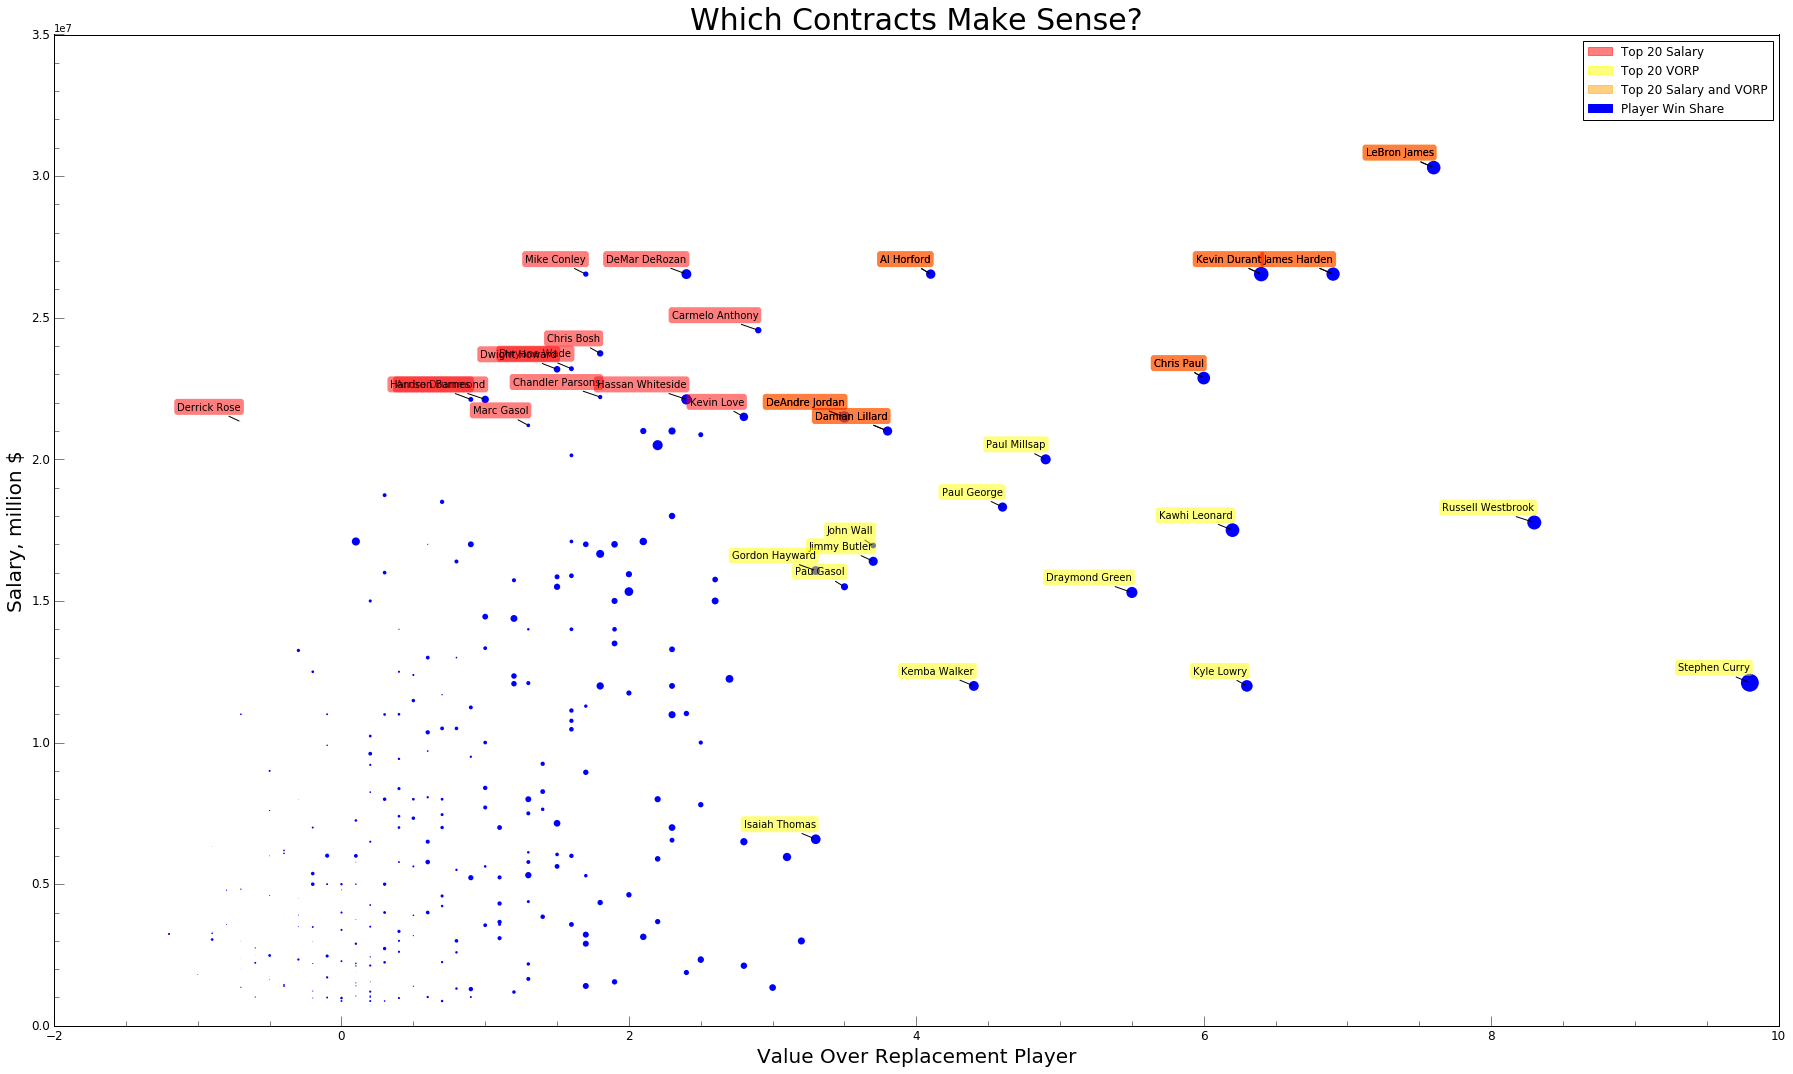

In [77]:
plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', length=10, top=False, right=False, color='black', bottom=True, left=True, labelsize='large')
plt.minorticks_on()
red_patch = mpatches.Patch(color='red', label='Top 20 Salary', alpha=0.5)
yellow_patch = mpatches.Patch(color='yellow', label='Top 20 VORP', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='Top 20 Salary and VORP', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='Player Win Share')
plt.legend(handles=[red_patch, yellow_patch, orange_patch, blue_patch])
plt.tick_params(axis='both', which='minor', length=5, top=False, right=False, color='black', 
                bottom=True, left=True, labelsize='small', labelbottom=True, labelleft=True)
plt.title('Which Contracts Make Sense?', fontsize='30')
plt.xlim(-2,10)
plt.xlabel('Value Over Replacement Player', fontsize='20')
plt.ylim(0,35000000)
plt.ylabel('Salary, million $', fontsize='20')
plt.legend()
plt.scatter(
    df['VORP'], df['Salary'], marker = 'o', 
    s = df['WS']**2,
    linewidths=0)
for label, x, y in zip(top_VORP['Player'], top_VORP['VORP'], top_VORP['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'yellow', alpha = 0.5, ec="none"),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))
for label, x, y in zip(top_Salary['Player'], top_Salary['VORP'], top_Salary['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'red', alpha = 0.5, ec="none"),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

plt.tight_layout()
plt.savefig('nba_player_values_VORP_v1.pdf', transparent=True)
plt.show()

In [79]:
df['PER/mil']=df['PER']/(df['Salary']/1000000)

In [83]:
df[['Player', 'PER/mil', 'MP']].sort_values(by='PER/mil', ascending=False).head(10)

,Player,PER/mil,MP
24,Andrea Bargnani,36.464884,634
350,Jeff Withey,17.426474,658
214,T.J. McConnell,16.578325,1606
174,Nikola Jokic,15.925926,1733
182,Sean Kilpatrick,15.911370,616
273,Norman Powell,15.206326,725
149,Richaun Holmes,15.142857,702
127,JaMychal Green,14.891410,1446
56,Clint Capela,14.117756,1471
297,Jonathon Simmons,13.605660,813


In [258]:
top_value=df.sort_values(by='PER/mil', ascending=False).head(10)

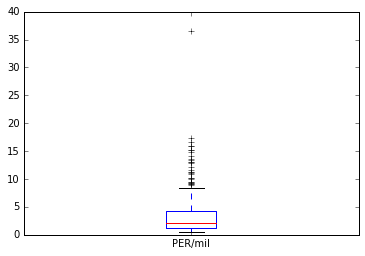

In [259]:
df['PER/mil'].plot(kind='box')

In [262]:
bottom_PER=df.sort_values(by='PER', ascending=True).head(20)

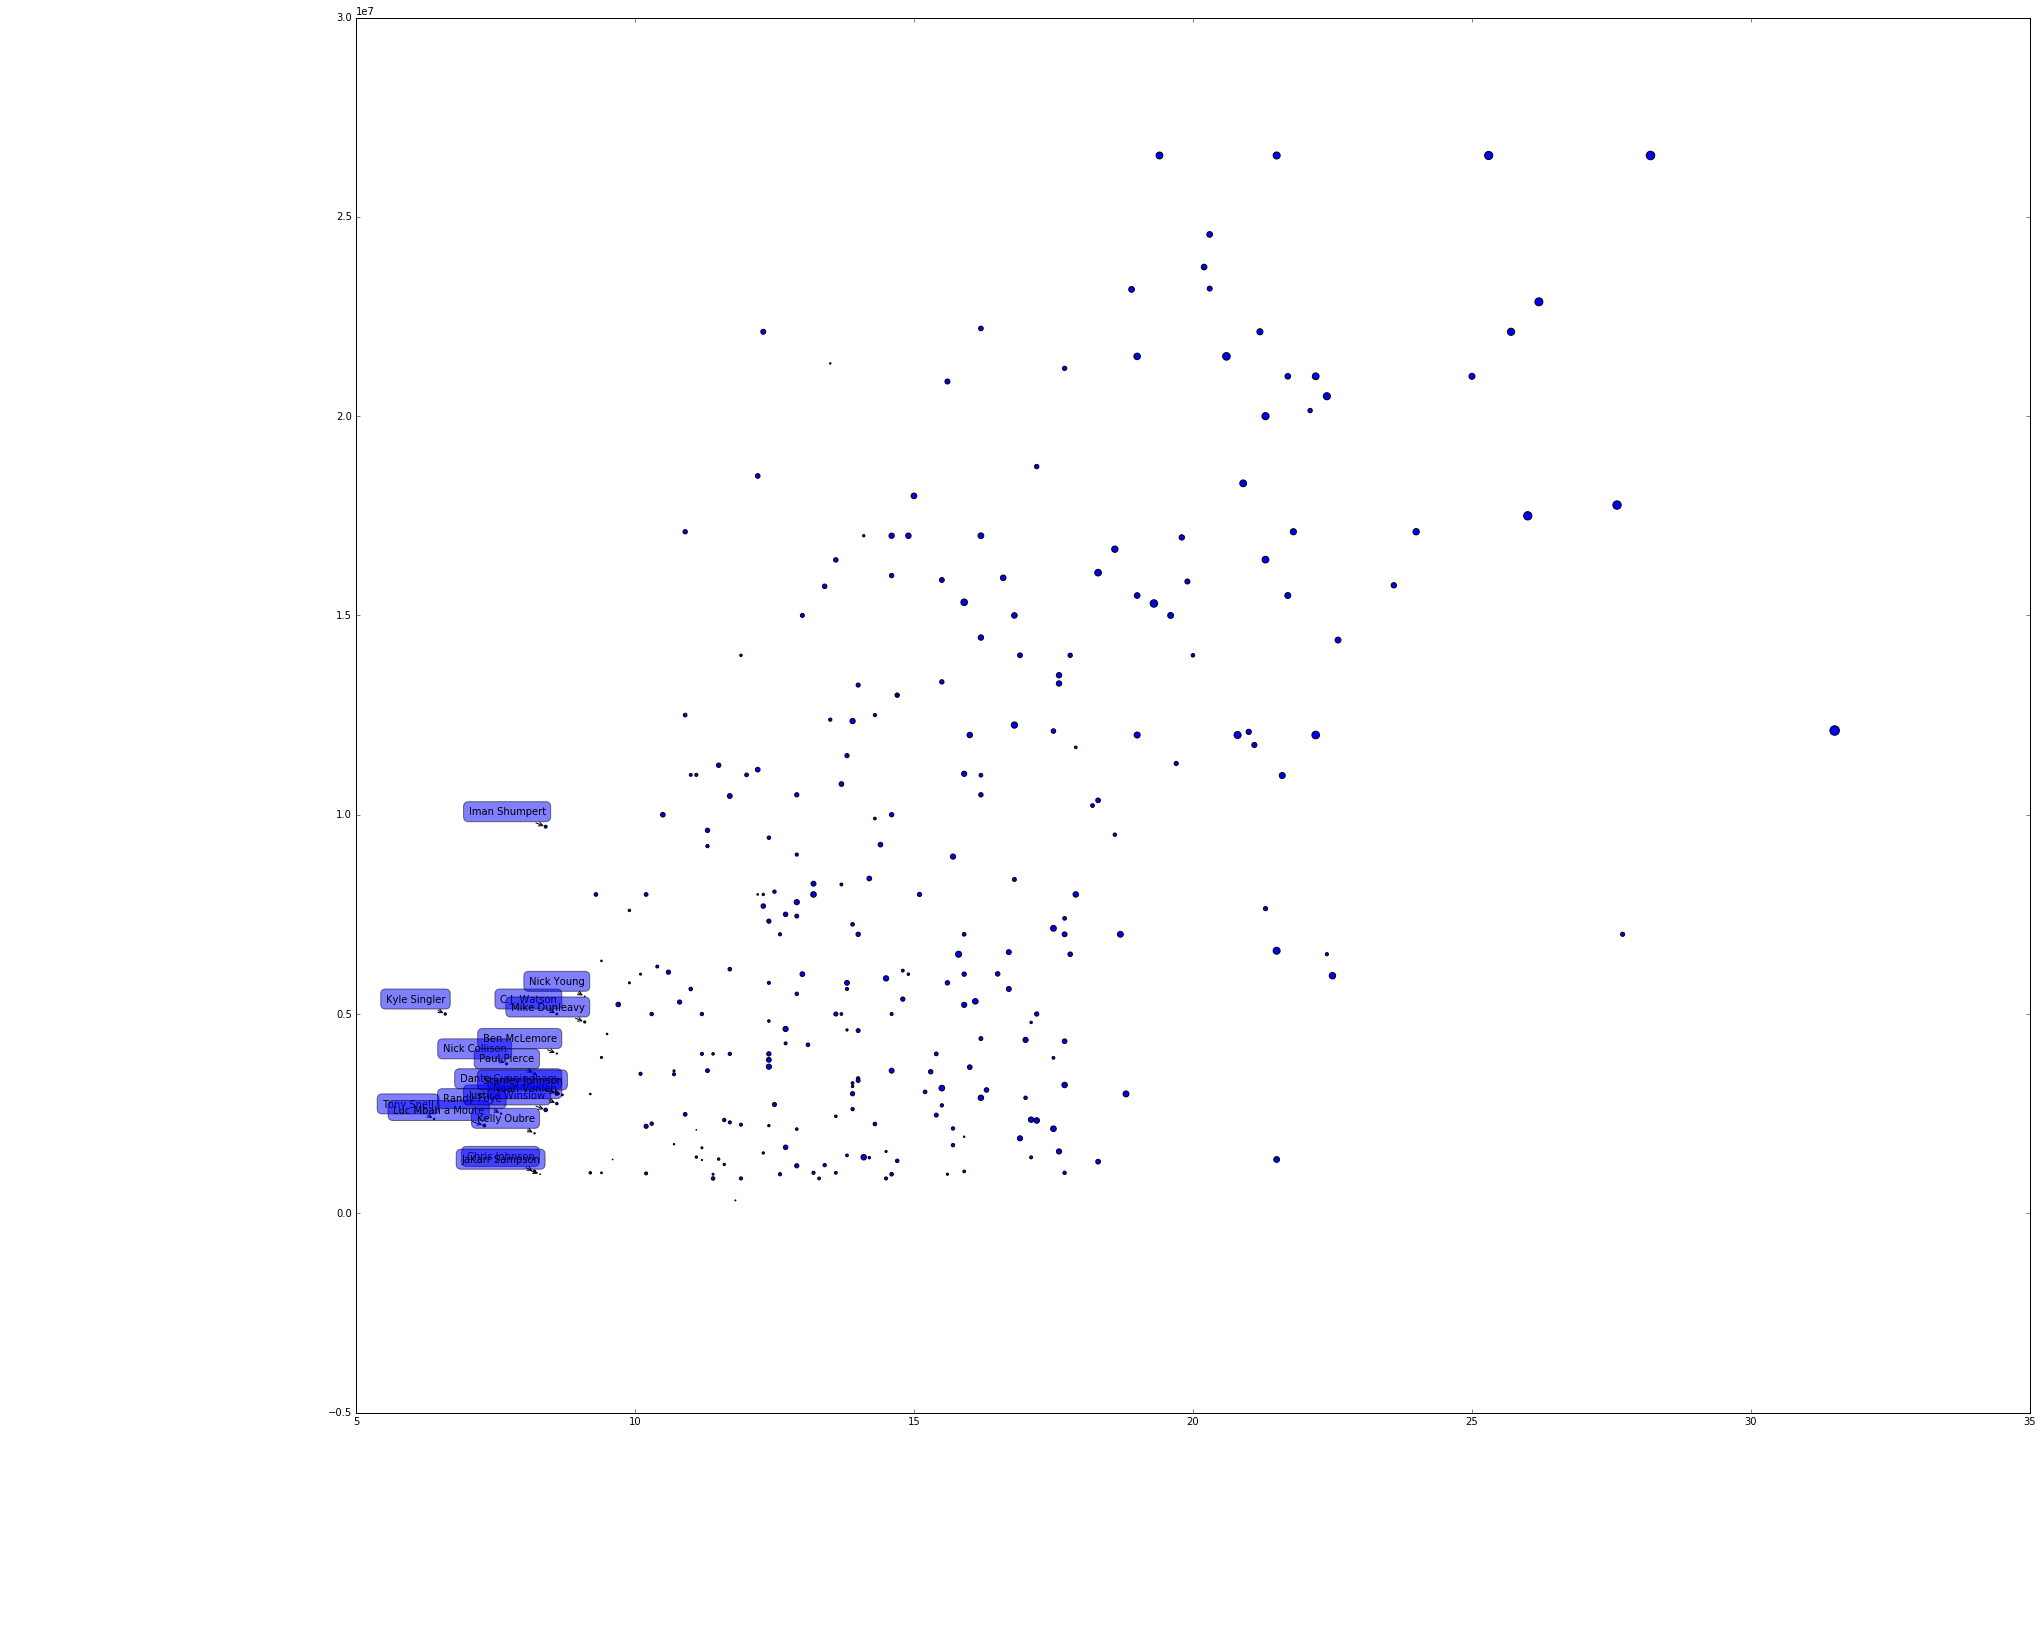

In [263]:
plt.figure(figsize=(30,25))
plt.scatter(
    df['PER'], df['Salary'], marker = 'o', 
    #c = df['WS/48'], 
    s = df['WS']*5,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(bottom_PER['Player'], bottom_PER['PER'], bottom_PER['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'blue', alpha = 0.5),
         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [338]:
bottom_value=df[df['PER']<=15].sort_values(by='PER/mil', ascending=True).head(10)
top_value=df[df['PER']>=20].sort_values(by='PER/mil', ascending=False).head(10)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


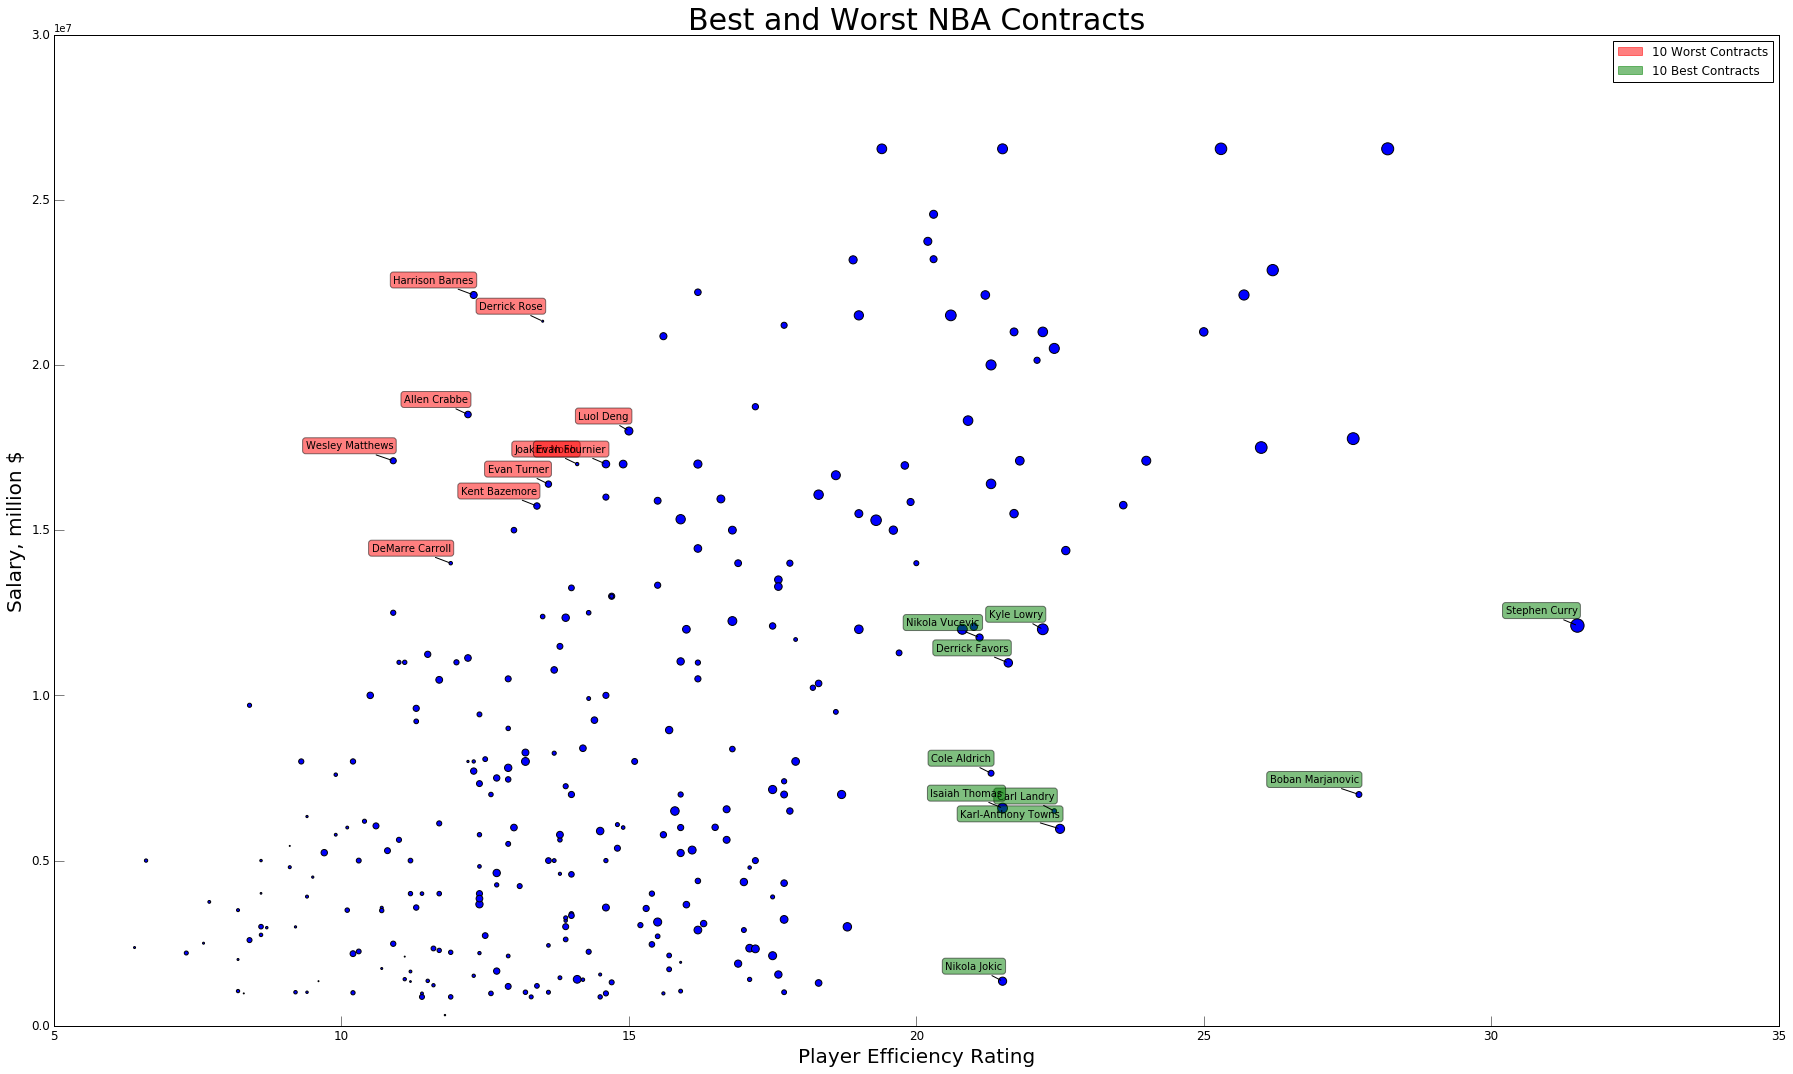

In [403]:
plt.figure(figsize=(25,15))
plt.tick_params(axis='both', which='major', length=10, top=False, right=False, color='black', bottom=True, left=True, labelsize='large')

red_patch = mpatches.Patch(color='red', label='10 Worst Contracts', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='10 Best Contracts', alpha=0.5)
plt.legend(handles=[red_patch, green_patch])
plt.tick_params(axis='both', which='minor', length=5, top=False, right=False, color='black', 
                bottom=True, left=True, labelsize='small', labelbottom=True, labelleft=True)
plt.title('Best and Worst NBA Contracts', fontsize='30')
plt.xlim(5,35)
plt.xlabel('Player Efficiency Rating', fontsize='20')
plt.ylim(0,30000000)
plt.ylabel('Salary, million $', fontsize='20')
plt.legend()
plt.scatter(
    df['PER'], df['Salary'], marker = 'o', 
    #c = df['WS/48'], 
    s = df['WS']*10,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(bottom_value['Player'], bottom_value['PER'], bottom_value['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'red', alpha = 0.5),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))
for label, x, y in zip(top_value['Player'], top_value['PER'], top_value['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.3', fc = 'green', alpha = 0.5),
         arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

   
plt.tight_layout()
#plt.savefig('nba_best_&_worst_contracts.pdf', transparent=True)
plt.show()

In [157]:
for label, x, y in zip(df['Player'], df['PER'], df['Salary']):
    print(label,x,y)

Steven Adams 15.5 3140517
Arron Afflalo 10.9 12500000
Alexis Ajinca 13.8 4600000
Cole Aldrich 21.3 7643979
LaMarcus Aldridge 22.4 20500000
Lavoy Allen 12.4 4000000
Tony Allen 12.9 5505618
Al-Farouq Aminu 12.7 7500000
Justin Anderson 12.3 1514160
Kyle Anderson 12.9 1192080
Ryan Anderson 17.2 18735364
Giannis Antetokounmpo 18.8 2995421
Carmelo Anthony 20.3 24559380
Trevor Ariza 12.9 7806971
Darrell Arthur 12.5 8070175
Omer Asik 11.0 11000000
D.J. Augustin 13.9 7250000
Luke Babbitt 11.6 1227000
Leandro Barbosa 11.7 4000000
J.J. Barea 15.4 4000000
Andrea Bargnani 11.8 323599
Harrison Barnes 12.3 22116750
Matt Barnes 11.7 6125000
Will Barton 16.0 3666666
Nicolas Batum 15.6 20869566
Jerryd Bayless 12.4 9424084
Aron Baynes 17.8 6500000
Kent Bazemore 13.4 15730338
Marco Belinelli 9.4 6333333
Patrick Beverley 13.0 6000000
Bismack Biyombo 14.9 17000000
Nemanja Bjelica 11.2 4000000
Eric Bledsoe 20.0 14000001
Bojan Bogdanovic 10.7 3573020
Andrew Bogut 15.9 11027027
Devin Booker 11.9 2223600
Trevor

In [274]:
top_100_per=df.sort_values(by='PER', ascending=False).head(100)
top_100_per

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil
75,Stephen Curry,PG,27,2700,31.5,0.669,17.9,0.318,12.5,9.8,GSW,12112359,12112359,2.600649
94,Kevin Durant,SF,27,2578,28.2,0.634,14.5,0.270,7.9,6.4,GSW,26540100,26540100,1.062543
206,Boban Marjanovic,C,27,508,27.7,0.662,3.4,0.325,3.6,0.7,DET,7000000,21000000,3.957143
338,Russell Westbrook,PG,27,2750,27.6,0.554,14.0,0.245,10.0,8.3,OKC,17769374,17769374,1.553234
260,Chris Paul,PG,30,2420,26.2,0.575,12.7,0.253,7.8,6.0,LAC,22868828,22868828,1.145664
191,Kawhi Leonard,SF,24,2380,26.0,0.616,13.7,0.277,8.3,6.2,SAS,17500000,56500000,1.485714
339,Hassan Whiteside,C,26,2125,25.7,0.629,10.3,0.233,2.5,2.4,MIA,22116750,71326519,1.162015
131,James Harden,SG,26,3125,25.3,0.598,13.3,0.204,6.7,6.9,HOU,26540100,85271293,0.953274
77,Anthony Davis,PF,22,2164,25.0,0.559,7.2,0.160,2.2,2.3,NOP,21000000,119500000,1.190476
178,Enes Kanter,C,23,1721,24.0,0.626,8.1,0.226,-1.7,0.1,OKC,17100000,35000000,1.403509


In [282]:
top_50_salary=df.sort_values(by='Salary', ascending=False).head(50)
top_10_salary_value=df.sort_values(by='PER/mil', ascending=False).head(10)
top_100_best_value

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil
349,Jeff Withey,C,25,658,17.7,0.577,2.3,0.171,1.7,0.6,UTA,1015696,0,17.426474
173,Nikola Jokic,C,20,1733,21.5,0.582,6.7,0.185,4.8,3.0,DEN,1350000,2750000,15.925926
56,Clint Capela,C,21,1471,18.3,0.553,4.4,0.144,0.5,0.9,HOU,1296240,1296240,14.117756
303,Marreese Speights,C,28,832,17.1,0.506,1.8,0.102,-3.9,-0.4,LAC,1403611,1403611,12.182863
337,David West,PF,35,1404,17.6,0.573,5.4,0.184,3.4,1.9,GSW,1551659,1551659,11.342698
92,Tim Duncan,C,39,1536,16.9,0.523,5.2,0.163,4.1,2.4,SAS,1881250,5643750,8.983389
117,Rudy Gobert,C,23,1932,17.5,0.582,6.4,0.160,3.7,2.8,UTA,2121288,2121288,8.249705
267,Mason Plumlee,C,25,2084,17.2,0.564,6.1,0.140,2.8,2.5,POR,2328530,2328530,7.386634
86,Gorgui Dieng,C,26,2220,17.1,0.601,5.9,0.127,2.4,2.5,MIN,2348783,2348783,7.280366
13,Giannis Antetokounmpo,PG,21,2823,18.8,0.566,7.1,0.121,2.4,3.2,MIL,2995421,2995421,6.276246


In [277]:
top_100_best_value=top_100_per.sort_values(by='PER/mil', ascending=False).head(10)
top_100_best_value

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil
349,Jeff Withey,C,25,658,17.7,0.577,2.3,0.171,1.7,0.6,UTA,1015696,0,17.426474
173,Nikola Jokic,C,20,1733,21.5,0.582,6.7,0.185,4.8,3.0,DEN,1350000,2750000,15.925926
56,Clint Capela,C,21,1471,18.3,0.553,4.4,0.144,0.5,0.9,HOU,1296240,1296240,14.117756
303,Marreese Speights,C,28,832,17.1,0.506,1.8,0.102,-3.9,-0.4,LAC,1403611,1403611,12.182863
337,David West,PF,35,1404,17.6,0.573,5.4,0.184,3.4,1.9,GSW,1551659,1551659,11.342698
92,Tim Duncan,C,39,1536,16.9,0.523,5.2,0.163,4.1,2.4,SAS,1881250,5643750,8.983389
117,Rudy Gobert,C,23,1932,17.5,0.582,6.4,0.160,3.7,2.8,UTA,2121288,2121288,8.249705
267,Mason Plumlee,C,25,2084,17.2,0.564,6.1,0.140,2.8,2.5,POR,2328530,2328530,7.386634
86,Gorgui Dieng,C,26,2220,17.1,0.601,5.9,0.127,2.4,2.5,MIN,2348783,2348783,7.280366
13,Giannis Antetokounmpo,PG,21,2823,18.8,0.566,7.1,0.121,2.4,3.2,MIL,2995421,2995421,6.276246


In [290]:
df.sort_values(by='VORP', ascending=False).head(10)

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil
75,Stephen Curry,PG,27,2700,31.5,0.669,17.9,0.318,12.5,9.8,GSW,12112359,12112359,2.600649
338,Russell Westbrook,PG,27,2750,27.6,0.554,14.0,0.245,10.0,8.3,OKC,17769374,17769374,1.553234
131,James Harden,SG,26,3125,25.3,0.598,13.3,0.204,6.7,6.9,HOU,26540100,85271293,0.953274
94,Kevin Durant,SF,27,2578,28.2,0.634,14.5,0.270,7.9,6.4,GSW,26540100,26540100,1.062543
201,Kyle Lowry,PG,29,2851,22.2,0.578,11.6,0.196,6.8,6.3,TOR,12000000,12000000,1.850000
191,Kawhi Leonard,SF,24,2380,26.0,0.616,13.7,0.277,8.3,6.2,SAS,17500000,56500000,1.485714
260,Chris Paul,PG,30,2420,26.2,0.575,12.7,0.253,7.8,6.0,LAC,22868828,22868828,1.145664
126,Draymond Green,PF,25,2808,19.3,0.587,11.1,0.190,5.8,5.5,GSW,15300000,67700000,1.261438
228,Paul Millsap,PF,30,2647,21.3,0.556,10.1,0.183,5.3,4.9,ATL,20000000,20000000,1.065000
114,Paul George,SF,25,2819,20.9,0.557,9.2,0.157,4.5,4.6,IND,18314532,37823490,1.141170


In [292]:
df['VORP/mil']=df['VORP']/(df['Salary']/1000000)
df

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil,VORP/mil
1,Steven Adams,C,22,2014,15.5,0.621,6.5,0.155,2.1,2.1,OKC,3140517,3140517,4.935493,0.668680
2,Arron Afflalo,SG,30,2371,10.9,0.531,2.7,0.055,-2.4,-0.2,SAC,12500000,14000000,0.872000,-0.016000
3,Alexis Ajinca,C,27,861,13.8,0.514,1.0,0.058,-4.5,-0.5,NOP,4600000,14800000,3.000000,-0.108696
4,Cole Aldrich,C,27,800,21.3,0.626,3.5,0.209,4.8,1.4,MIN,7643979,17000000,2.786507,0.183151
5,LaMarcus Aldridge,PF,30,2261,22.4,0.565,10.1,0.215,1.8,2.2,SAS,20500000,42000000,1.092683,0.107317
7,Lavoy Allen,PF,26,1599,12.4,0.532,3.7,0.110,-0.6,0.6,IND,4000000,4000000,3.100000,0.150000
8,Tony Allen,SG,34,1620,12.9,0.505,2.4,0.072,-0.1,0.8,MEM,5505618,5505618,2.343061,0.145306
9,Al-Farouq Aminu,SF,25,2341,12.7,0.533,4.0,0.082,0.2,1.3,POR,7500000,22500000,1.693333,0.173333
10,Justin Anderson,SF,22,647,12.3,0.522,1.1,0.083,-1.2,0.1,DAL,1514160,1514160,8.123316,0.066043
11,Kyle Anderson,SF,22,1245,12.9,0.528,3.5,0.133,1.8,1.2,SAS,1192080,1192080,10.821421,1.006644


In [313]:
top_10_young=df[df['Age']<25].sort_values(by='PER', ascending=False).head(10)
top_10_young

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil,VORP/mil
191,Kawhi Leonard,SF,24,2380,26.0,0.616,13.7,0.277,8.3,6.2,SAS,17500000,56500000,1.485714,0.354286
77,Anthony Davis,PF,22,2164,25.0,0.559,7.2,0.160,2.2,2.3,NOP,21000000,119500000,1.190476,0.109524
178,Enes Kanter,C,23,1721,24.0,0.626,8.1,0.226,-1.7,0.1,OKC,17100000,35000000,1.403509,0.005848
324,Jonas Valanciunas,C,23,1557,22.6,0.610,6.9,0.211,1.1,1.2,TOR,14382022,46382023,1.571406,0.083438
320,Karl-Anthony Towns,C,20,2627,22.5,0.590,8.3,0.151,2.8,3.1,MIN,5960160,5960160,3.775066,0.520120
104,Derrick Favors,PF,24,1983,21.6,0.551,7.1,0.173,2.7,2.3,UTA,10983333,22550000,1.966616,0.209408
173,Nikola Jokic,C,20,1733,21.5,0.582,6.7,0.185,4.8,3.0,DEN,1350000,2750000,15.925926,2.222222
90,Andre Drummond,C,22,2666,21.2,0.499,7.4,0.133,-0.5,1.0,DET,22116750,98419538,0.958550,0.045215
159,Kyrie Irving,PG,23,1667,19.9,0.540,5.0,0.143,1.6,1.5,CLE,15851950,50873700,1.255366,0.094626
13,Giannis Antetokounmpo,PG,21,2823,18.8,0.566,7.1,0.121,2.4,3.2,MIL,2995421,2995421,6.276246,1.068297


In [311]:
df[df['Player']=='Kyrie Irving']

,Player,Pos,Age,MP,PER,TS%,WS,WS/48,BPM,VORP,Tm,Salary,Total Contract,PER/mil,VORP/mil
159,Kyrie Irving,PG,23,1667,19.9,0.54,5.0,0.143,1.6,1.5,CLE,15851950,50873700,1.255366,0.094626


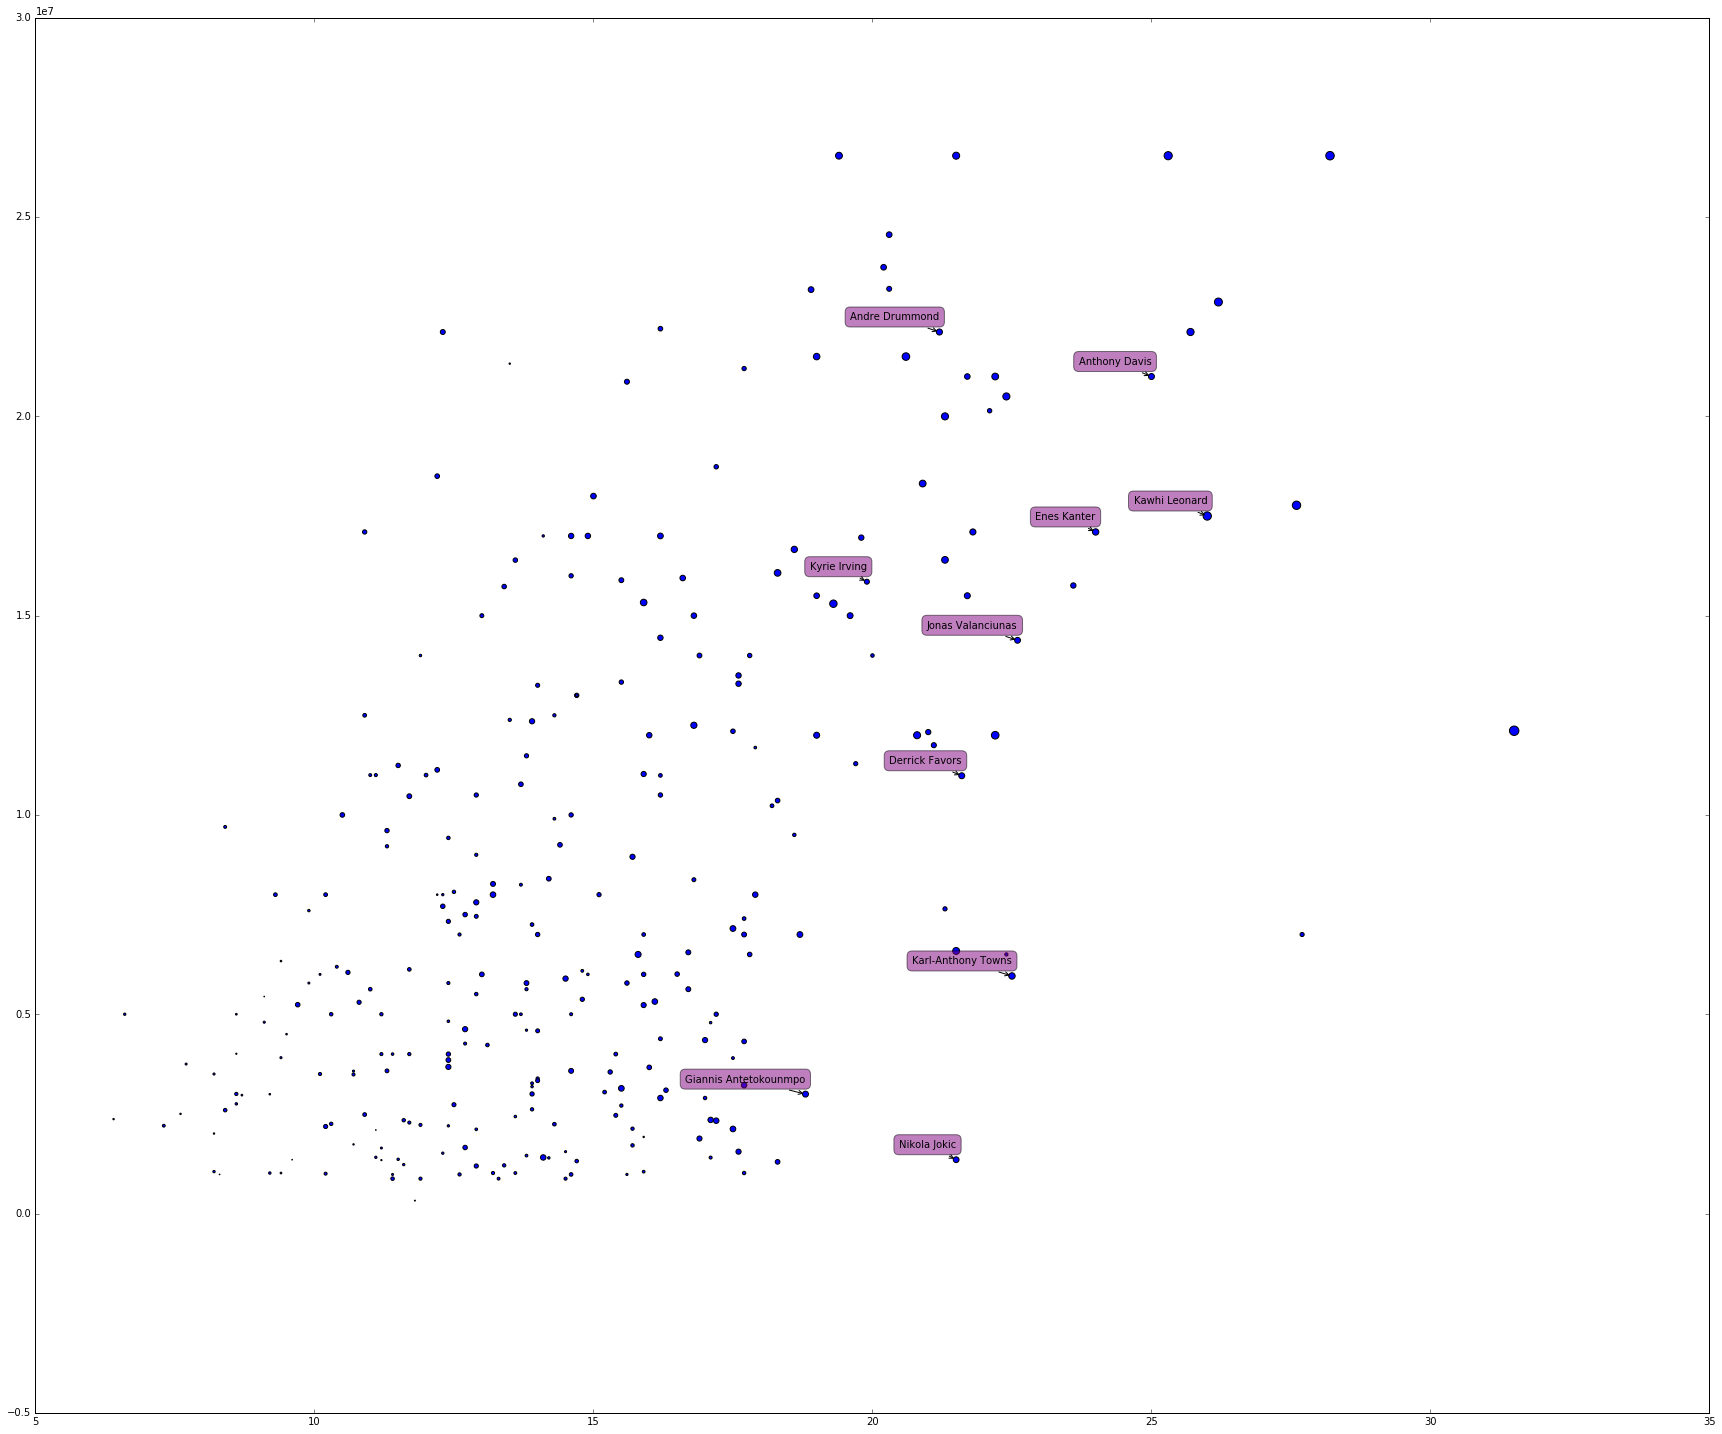

In [314]:
plt.figure(figsize=(30,25))
plt.scatter(
    df['PER'], df['Salary'], marker = 'o', 
    #c = df['WS/48'], 
    s = df['WS']*5,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(top_10_young['Player'], top_10_young['PER'], top_10_young['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'purple', alpha = 0.5),
         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
# for label, x, y in zip(top_Salary['Player'], top_Salary['PER'], top_Salary['Salary']):
#      plt.annotate(
#          label, 
#          xy = (x, y), xytext = (0,10),
#          textcoords = 'offset points', ha = 'right', va = 'bottom',
#          bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
#          arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#plt.savefig('nba_player_values.pdf', transparent=True)
plt.show()

In [285]:
centers=df[df['Pos']=='C']

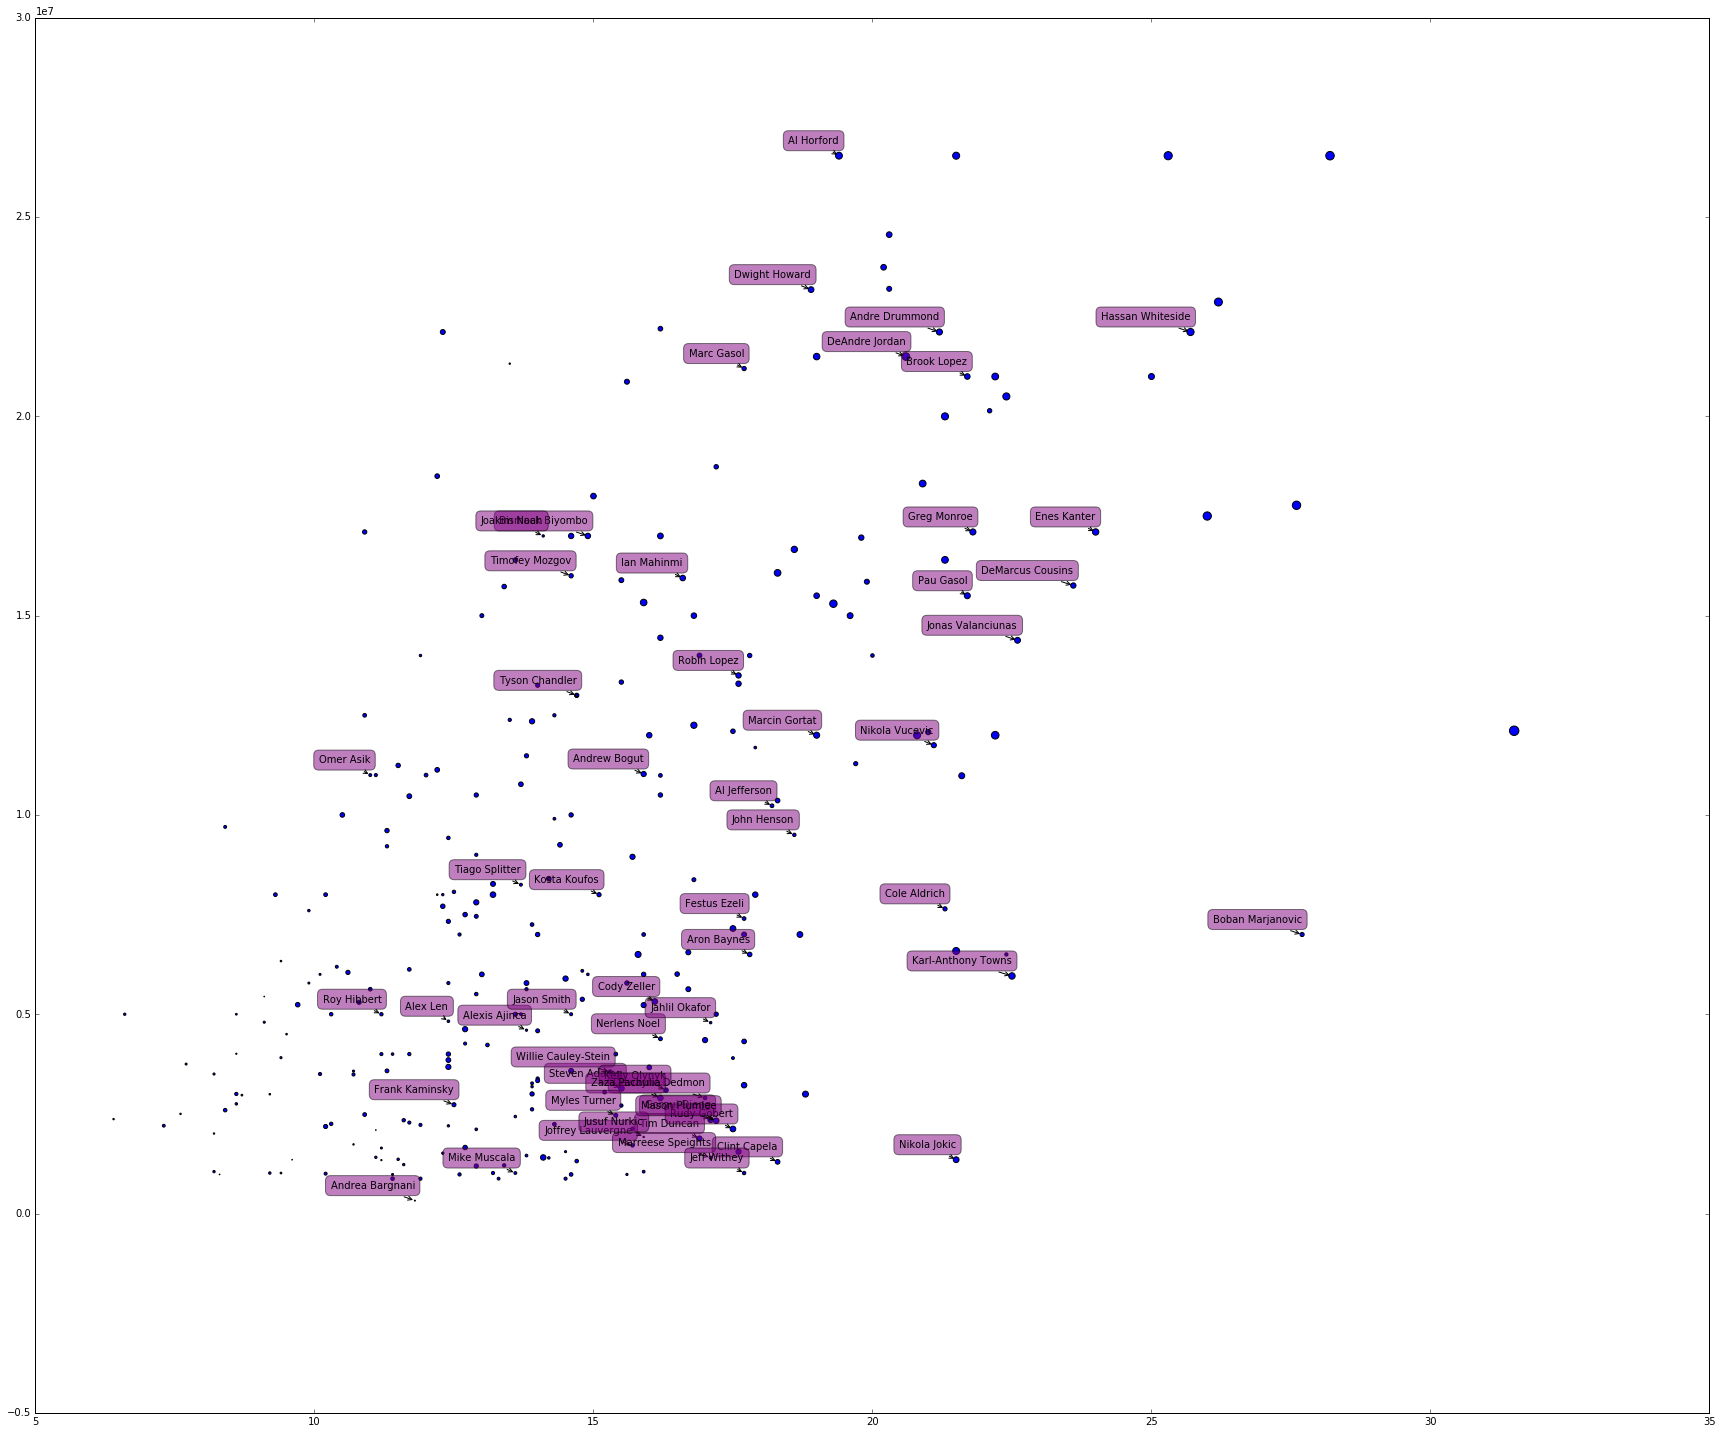

In [286]:
plt.figure(figsize=(30,25))
plt.scatter(
    df['PER'], df['Salary'], marker = 'o', 
    #c = df['WS/48'], 
    s = df['WS']*5,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(centers['Player'], centers['PER'], centers['Salary']):
     plt.annotate(
         label, 
         xy = (x, y), xytext = (0,10),
         textcoords = 'offset points', ha = 'right', va = 'bottom',
         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'purple', alpha = 0.5),
         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
# for label, x, y in zip(top_Salary['Player'], top_Salary['PER'], top_Salary['Salary']):
#      plt.annotate(
#          label, 
#          xy = (x, y), xytext = (0,10),
#          textcoords = 'offset points', ha = 'right', va = 'bottom',
#          bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
#          arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#plt.savefig('nba_player_values.pdf', transparent=True)
plt.show()

In [288]:
len(top_100_salary)

100

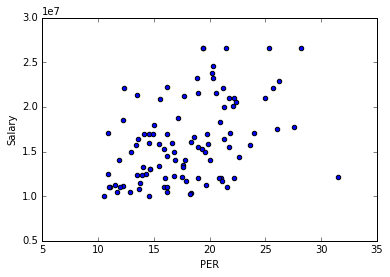

In [273]:
top_100_salary.plot(kind='scatter', x='PER', y='Salary')

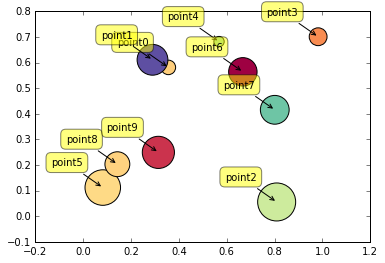

In [147]:
# whole bunch of code borrowed/stolen from here:
# http://stackoverflow.com/questions/5147112/matplotlib-how-to-put-individual-tags-for-a-scatter-plot
N = 10
data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker = 'o', c = data[:, 2], s = data[:, 3]*1500,
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [142]:
data[:, 0]

array([ 0.01415227,  0.72641295,  0.56211633,  0.02594057,  0.9659323 ,
        0.20767789,  0.0507811 ,  0.83177831,  0.63953348,  0.97018152])

In [141]:
data

array([[ 0.01415227,  0.6586497 ,  0.75430877,  0.46003504],
       [ 0.72641295,  0.63558556,  0.82409092,  0.65510729],
       [ 0.56211633,  0.44301851,  0.47963643,  0.46371789],
       [ 0.02594057,  0.12943731,  0.51155112,  0.10569308],
       [ 0.9659323 ,  0.10876738,  0.32700724,  0.86029108],
       [ 0.20767789,  0.74370577,  0.8605256 ,  0.25067937],
       [ 0.0507811 ,  0.28157566,  0.07524589,  0.48203075],
       [ 0.83177831,  0.5632486 ,  0.92272314,  0.88150153],
       [ 0.63953348,  0.56736223,  0.72937104,  0.3487405 ],
       [ 0.97018152,  0.14137732,  0.14597527,  0.15600198]])

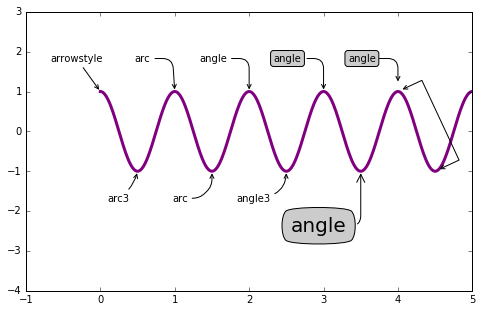

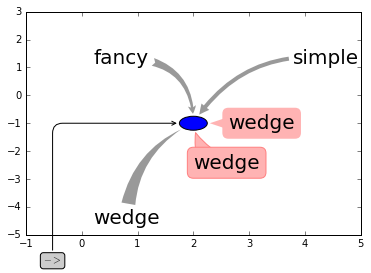

In [354]:
# i borrowed all this just for examples. (mostly to figure out which thing got rid of the awful borders on the text bubbles)
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

if 1:
    fig = plt.figure(1, figsize=(8, 5))
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 5), ylim=(-4, 3))

    t = np.arange(0.0, 5.0, 0.01)
    s = np.cos(2*np.pi*t)
    line, = ax.plot(t, s, lw=3, color='purple')

    ax.annotate('arrowstyle', xy=(0, 1), xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )

    ax.annotate('arc3', xy=(0.5, -1), xycoords='data',
                xytext=(-30, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=.2")
                )

    ax.annotate('arc', xy=(1., 1), xycoords='data',
                xytext=(-40, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc,angleA=0,armA=30,rad=10"),
                )

    ax.annotate('arc', xy=(1.5, -1), xycoords='data',
                xytext=(-40, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc,angleA=0,armA=20,angleB=-90,armB=15,rad=7"),
                )

    ax.annotate('angle', xy=(2., 1), xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )

    ax.annotate('angle3', xy=(2.5, -1), xycoords='data',
                xytext=(-50, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

    ax.annotate('angle', xy=(3., 1), xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )

    ax.annotate('angle', xy=(3.5, -1), xycoords='data',
                xytext=(-70, -60), textcoords='offset points',
                size=20,
                bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="angle,angleA=0,angleB=-90,rad=10"),
                )

    ax.annotate('angle', xy=(4., 1), xycoords='data',
                xytext=(-50, 30), textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                shrinkA=0, shrinkB=10,
                                connectionstyle="angle,angleA=0,angleB=90,rad=10"),
                )

    ann = ax.annotate('', xy=(4., 1.), xycoords='data',
                      xytext=(4.5, -1), textcoords='data',
                      arrowprops=dict(arrowstyle="<->",
                                      connectionstyle="bar",
                                      ec="k",
                                      shrinkA=5, shrinkB=5,
                                      )
                      )


if 1:
    fig = plt.figure(2)
    fig.clf()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 5), ylim=(-5, 3))

    el = Ellipse((2, -1), 0.5, 0.5)
    ax.add_patch(el)

    ax.annotate('$->$', xy=(2., -1), xycoords='data',
                xytext=(-150, -140), textcoords='offset points',
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="->",
                                patchB=el,
                                connectionstyle="angle,angleA=90,angleB=0,rad=10"),
                )

    ax.annotate('fancy', xy=(2., -1), xycoords='data',
                xytext=(-100, 60), textcoords='offset points',
                size=20,
                # bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="fancy",
                                fc="0.6", ec="none",
                                patchB=el,
                                connectionstyle="angle3,angleA=0,angleB=-90"),
                )

    ax.annotate('simple', xy=(2., -1), xycoords='data',
                xytext=(100, 60), textcoords='offset points',
                size=20,
                # bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none",
                                patchB=el,
                                connectionstyle="arc3,rad=0.3"),
                )

    ax.annotate('wedge', xy=(2., -1), xycoords='data',
                xytext=(-100, -100), textcoords='offset points',
                size=20,
                # bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle="wedge,tail_width=0.7",
                                fc="0.6", ec="none",
                                patchB=el,
                                connectionstyle="arc3,rad=-0.3"),
                )

    ann = ax.annotate('wedge', xy=(2., -1), xycoords='data',
                      xytext=(0, -45), textcoords='offset points',
                      size=20,
                      bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec=(1., .5, .5)),
                      arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"),
                      )

    ann = ax.annotate('wedge', xy=(2., -1), xycoords='data',
                      xytext=(35, 0), textcoords='offset points',
                      size=20, va="center",
                      bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"),
                      arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1.0, 0.7, 0.7), ec="none",
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.5),
                                      )
                      )


plt.show()

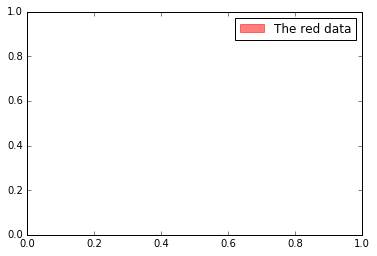

In [387]:
# this was a model (stolen from the internet) for my dummy legend
red_patch = mpatches.Patch(color='red', label='The red data', alpha=0.5)
plt.legend(handles=[red_patch])